# Tarea 1 - Pattern Recognition

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import accuracy_score
import matplotlib.patches as mpatches
from scipy.linalg import svd
from sklearn.decomposition import TruncatedSVD
import pandas as pd
import os
plt.rcParams["figure.figsize"] = [16,9]

We are only considering 28 persons (from B11 to B39 because person B14 do not exist).

Images have the following format : 168x192.

In [6]:
# full path until the directory Cropped Yale
main_path = "/u/a/2019/apoupeau/Documentos/recpatr/face-recognition/CroppedYale"
main_path = "/home/osboxes/Documents/python/recpatr/face-recognition/CroppedYale"

# defining the persons we consider 
dict_B_considered = {11:0, 12:1, 13:2, 15:3, 16:4, 17:5, 18:6, 19:7, 20:8, 
                      21:9, 22:10, 23:11, 24:12, 25:13, 26:14, 
                      27:15, 28:16, 29:17, 30:18, 31:19, 32:20, 
                      33:21, 34:22, 35:23, 36:24, 37:25, 38:26, 39:27}

# max_illu_strength_coef_percent_train
max_ist_cpt = 15

In [7]:
def illuminationStrength(azimuth, elevation):
    """
        Returns:
            ist (int) : illumination strength = |azimuth|+|elevation|
    """
    return np.abs(azimuth) + np.abs(elevation)

In [8]:
def imgPathToArray(img_path):
    """
        Returns:
            img_1D_vec (array)
    """
    img = plt.imread(img_path, "pgm")
    rows, cols = img.shape # gives dimensions for Grey Scale array
    img_size = rows*cols
    img_1D_vec = img.reshape(img_size)
    return img_1D_vec

In [9]:
def getData(path, max_ist_cpt):
    """
        Arguments:
            mcpt (int) : |azimuth|+|elevation| <= max_illu_strength_coef_percent_train
    
        Returns:
            train_data (array) 
            train_label (array)
            test_data (array)
    """
    train_data, train_label, train_illu, test_data, test_label, test_illu  = list(), list(), list(), list(), list(), list()
    for yale_dirname in os.listdir(path):
        # keeping only the persons we want
        if int(yale_dirname[-2:]) in dict_B_considered.keys():
            cur_person_imgs_path = os.path.join(main_path, yale_dirname)
            for face_image in os.listdir(cur_person_imgs_path):
                # keeping only the images (no info or log files)
                if len(face_image) >= 13 and face_image[-13] == "A":
                    azimuth = int(face_image[-12:-8])
                    elevation = int(face_image[-7:-4])
                    cur_img_path = os.path.join(cur_person_imgs_path, face_image)
                    img_1D_vec = imgPathToArray(img_path=cur_img_path)
                    label_img = dict_B_considered[int(face_image[5:7])]
                    illu_img = np.array([azimuth, elevation])
                    # train element
                    if illuminationStrength(azimuth, elevation) <= max_ist_cpt:
                        train_data.append(img_1D_vec)
                        train_label.append(label_img)
                        train_illu.append(illu_img)
                    # test data
                    else:
                        test_data.append(img_1D_vec)
                        test_label.append(label_img)
                        test_illu.append(illu_img)
    return np.array(train_data, dtype=int), np.array(train_label, dtype=int), np.array(train_illu), np.array(test_data, dtype=int), np.array(test_label, dtype=int), np.array(test_illu)

In [10]:
train_data, train_label, train_illu, test_data, test_label, test_illu = getData(path=main_path, 
                                                                                max_ist_cpt=max_ist_cpt)

We miss three files B16_A-010_E00, B17_A-010_E00 and B18_A-010_E00 because those files are corrupted.

In [8]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax, cm


## RAW classification

In this part we are going to use the k-nearest-neighbours algorithm to solve the classification problem and see how well it performs on raw data on this specific dataset.

In [89]:
# train the knn model
knn_clf = KNeighborsClassifier(n_neighbors=1)
knn_clf.fit(train_data, train_label)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=1, p=2,
           weights='uniform')

Confusion matrix, without normalization


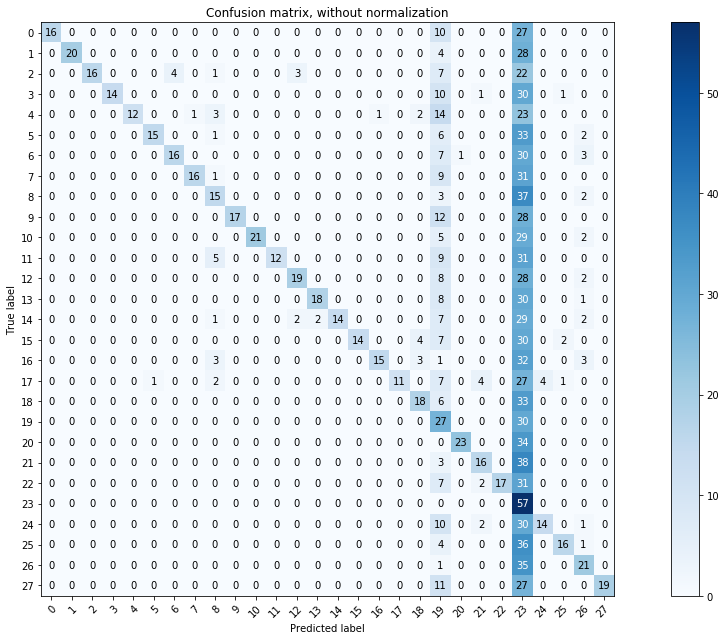

In [90]:
test_pred = knn_clf.predict(test_data)
ax, cm = plot_confusion_matrix(y_true=test_label, 
                                    y_pred=test_pred,
                                    classes=np.array(list(dict_B_considered.values()), dtype=int))

In [91]:
def computeAccFromk(max_k_value):
    """
    """
    acc = list()
    k_values = np.linspace(1, max_k_value, max_k_value, dtype=int)
    for k in k_values:
        knn_clf = KNeighborsClassifier(n_neighbors=k)
        knn_clf.fit(train_data, train_label)
        test_pred = knn_clf.predict(test_data)
        accuracy = accuracy_score(y_true=test_label, y_pred=test_pred)
        acc.append(accuracy)
    return np.array(acc)

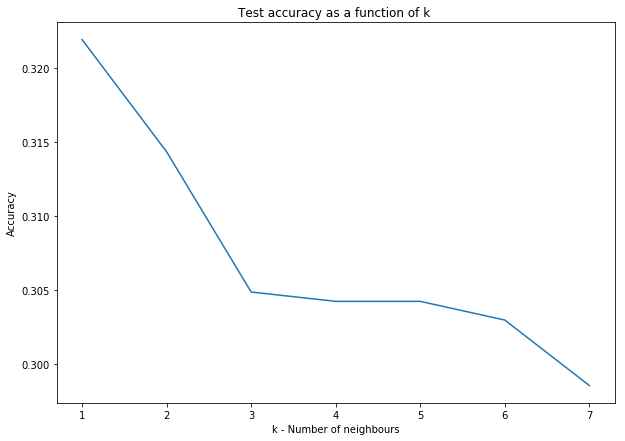

In [93]:
max_k_value = 7
k_values = np.linspace(1, max_k_value, max_k_value, dtype=int)
acc = computeAccFromk(max_k_value=max_k_value)

plt.figure(figsize=(10,7))
plt.plot(k_values, acc)
plt.title("Test accuracy as a function of k ")
plt.xlabel("k - Number of neighbours")
plt.ylabel("Accuracy")
plt.show()

In [11]:
def orderFromIst(k, ist_sep, max_ist = 175):
    """
        ist always <= 175
    """
    knn_clf = KNeighborsClassifier(n_neighbors=k)
    knn_clf.fit(train_data, train_label)
    test_pred = knn_clf.predict(test_data)
    test_ist = np.array([illuminationStrength(illu[0], illu[1]) for illu in test_illu])
   
    order_from_ist = list()
    for i in range(0, max_ist, ist_sep):
        order_from_ist.append(np.array([[test_label[idx], test_pred[idx]] for idx, ist in enumerate(test_ist) if i <= ist and ist <= i+ist_sep]))
    
    return np.array(order_from_ist)

In [16]:
order_from_ist = orderFromIst(k=1, ist_sep=20)

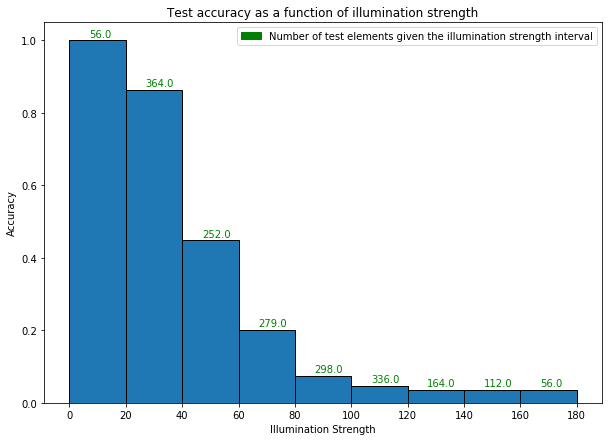

In [88]:
list_acc_ist = list()
for element in order_from_ist:
    acc = accuracy_score(y_true=element[:, 0], y_pred=element[:, 1])
    list_acc_ist.append([acc, int(element.shape[0])])
list_acc_ist = np.array(list_acc_ist)

z = np.linspace(0, 160, 9)
y = list_acc_ist[:, 0]
n = list_acc_ist[:, 1]

fig, ax = plt.subplots(figsize=(10,7))
plt.xticks(np.arange(0, 200, step=20))
ax.bar(z, y, width=20, align='edge', edgecolor='black')

for i, txt in enumerate(n):
    ax.annotate(txt, (z[i]+7, y[i]+0.01), color='green')

    
red_patch = mpatches.Patch(color='green', label='Number of test elements given the illumination strength interval')
plt.legend(handles=[red_patch])
plt.xlabel("Illumination Strength")
plt.ylabel("Accuracy")
plt.title("Test accuracy as a function of illumination strength")
plt.show()

## PCA before classification

In this part we apply PCA to diminish the dimension of the input data before classifying

In [69]:
def mySVDBoost(data, n_components=np.inf):
    """
    """
    data_shape = data.shape
    svd = TruncatedSVD(n_components=min(n_components, data_shape[1]))
    reduced_dim_data = svd.fit_transform(data)
    mean_vec = np.mean(data, axis=0)
    evr = svd.explained_variance_ratio_
    print("Explained variance :", evr)
    eigen_vectors = svd.components_
    print("Shape eigen vectors:", eigen_vectors.shape)
    return eigen_vectors, mean_vec

In [70]:
def myPCABoost(data, n_components=np.inf):
    """
    """
    data_shape = data.shape
    pca = PCA(n_components=min(n_components, data_shape[1]))
    reduced_dim_data = pca.fit_transform(data)
    mean_vec = np.mean(data, axis=0)
    evr = pca.explained_variance_ratio_
    print("Explained variance :", evr)
    eigen_vectors = pca.components_
    print("Shape eigen vectors:", eigen_vectors.shape)
    return eigen_vectors, mean_vec

In [10]:
def myPCA(data, n_components):
    """
    """
    A = data - np.mean(data, axis=0)
    print(A.shape)
    A = (1/A.shape[0])*np.matmul(A.T, A)
    print(A)
    # Singular-value decomposition
    U, s, VT = svd(A)
    # create m x n Sigma matrix
    Sigma = zeros((A.shape[0], A.shape[1]))
    # populate Sigma with n x n diagonal matrix
    Sigma[:A.shape[0], :A.shape[0]] = diag(s)
    # select
    n_elements = 2
    Sigma = Sigma[:, :n_elements]
    VT = VT[:n_elements, :]
    # reconstruct
    B = U.dot(Sigma.dot(VT))
    print(B)
    # transform
    T = U.dot(Sigma)
    print(T)
    T = A.dot(VT.T)
    print(T)

In [74]:
eigen_vectors, mean_vec = myPCABoost(train_data[0:10, :], n_components=3)

Explained variance : [0.50282595 0.22488919 0.12903891]
Shape eigen vectors: (3, 32256)


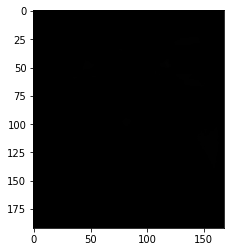

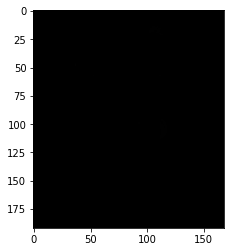

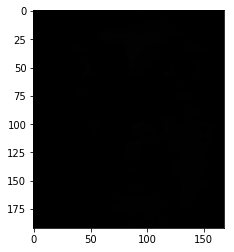

In [55]:
for vect in eigen_vectors:
    vect *= mean_vec
    vect = vect.reshape((192, 168))
    plt.imshow(vect, cmap='gray', vmin=0, vmax=255)
    plt.show()

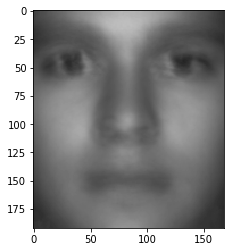

In [38]:
mean_train_image = mean_vec.reshape((192, 168))
plt.imshow(mean_train_image, cmap='gray', vmin=0, vmax=255)
plt.show()

(10, 32256)

In [156]:
model = TruncatedSVD(n_components=10)
model.fit(train_data)
reduced_train_data = model.transform(train_data)
reduced_test_data = model.transform(test_data)